## Imports

In [7]:
from autograd import Value, populate_dataframe, build_causal_graph, draw_computational_graph
import numpy as np
import pandas as pd
from shapflow.flow import GraphExplainer
import os

## Equation

In [8]:
def reversible_reaction_fn(x1, x2):
    Value.reset()

    beta_1 = Value(2, label='beta_1')
    beta_2 = Value(3, label='beta_2')

    x1 = Value(x1, label='x1')
    x2 = Value(x2, label='x2')

    y = beta_1 * x1 - beta_2 * x2**2
    y.label = 'y'

    return y

## Generate and Prepare Data

In [9]:
x1 = np.random.randn(2)
x2 = np.random.randn(2)

# Set the first two indices to our foreground and background sample
x1[0] = 0
x2[0] = 2
x1[1] = 1
x2[1] = 1

X = pd.DataFrame.from_dict({'x1': x1, 'x2': x2})
f = lambda x: x[:,0] + x[:,1] + x[:,0]*x[:,1]
f_d = pd.DataFrame.from_dict({
    'f': [
        reversible_reaction_fn(x1[0], x2[0]).data,
        reversible_reaction_fn(x1[1], x2[1]).data,
    ]
})
pd.concat((X, f_d), axis=1)

populate_dataframe(X, reversible_reaction_fn)
X

['x1', 'x2']


,x1,x2,beta_1,(x1*beta_1),beta_2,(x2**2),((x2**2)*beta_2),-1,(-((x2**2)*beta_2)),y
0,0.0,2.0,2.0,0.0,3.0,4.0,12.0,-1.0,-12.0,-12.0
1,1.0,1.0,2.0,2.0,3.0,1.0,3.0,-1.0,-3.0,-1.0


## Generate Computational Graph

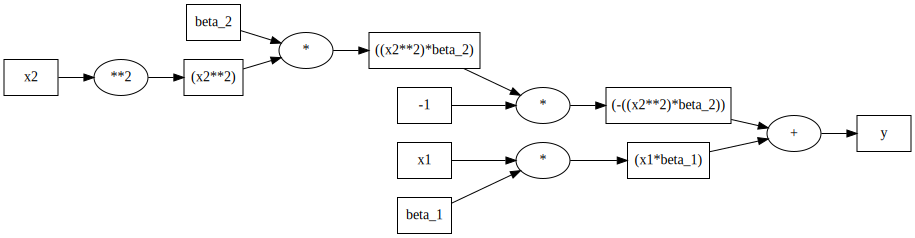

In [10]:
Value.reset()

y = reversible_reaction_fn(0.1, 0.1)
target_name = 'y'

computational_graph = draw_computational_graph(y, disable_data_field=True, disable_grad_field=True)
computational_graph

## Build Causal Graph

[(['-1', '((x2**2)*beta_2)'], ['(-((x2**2)*beta_2))'], [<function op_to_function.<locals>.mul at 0x168c9bba0>]), (['x2'], ['(x2**2)'], [functools.partial(<function op_to_function.<locals>.pow at 0x168c9bd80>, exponent=2)]), (['beta_1', 'x1'], ['(x1*beta_1)'], [<function op_to_function.<locals>.mul at 0x168c9bc40>]), (['(-((x2**2)*beta_2))', '(x1*beta_1)'], ['y'], [<function op_to_function.<locals>.add at 0x168c9be20>]), (['beta_2', '(x2**2)'], ['((x2**2)*beta_2)'], [<function op_to_function.<locals>.mul at 0x168c9bb00>])]


0it [00:00, ?it/s]


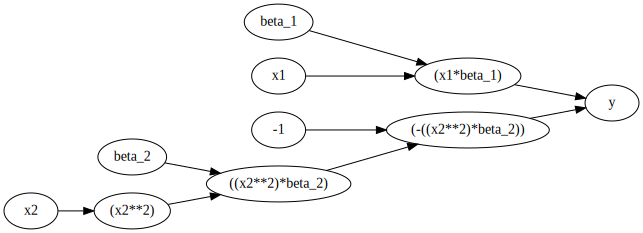

In [11]:
causal_graph = build_causal_graph(y, X.drop(columns=['y']), target_name)
causal_graph.draw(rankdir='LR')

## Shapley Flow Analysis

bruteforce sampling: 100%|██████████| 10000/10000 [00:01<00:00, 7044.62it/s]


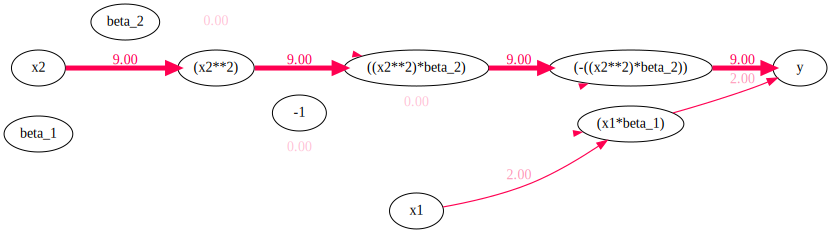

In [12]:
nruns = 10000 # number of monte carlo samples
sample_ind = 0
bg = X[:1] # background sample, no need for multiple sample because of the linearity axiom
fg = X[1:2] # foreground samples to explain

cf_flow = GraphExplainer(causal_graph, bg, nruns=nruns).shap_values(fg, rankdir='LR')
cf_flow.fold_noise = True
shapflow_graph = cf_flow.draw(sample_ind, show_fg_val=False)

## Save Results

In [13]:
dir_name = 'reversible_reaction'
save_dir = f'results/{dir_name}'
os.makedirs(save_dir, exist_ok=True)

computational_graph.render(os.path.join(save_dir, f'computational_graph'), format='png')
causal_graph.to_graphviz(rankdir='LR').draw(
    path=os.path.join(save_dir, f'causal_graph.png'),
    format='png',
    prog='dot'
)
shapflow_graph.draw(
    path=os.path.join(save_dir, f'shapflow_graph.png'),
    format='png',
    prog='dot'
)

print("All graphs have been saved to:", save_dir)

All graphs have been saved to: results/reversible_reaction
